# Twitter Stream 

In [7]:
import pandas as pd
import numpy as np
import tweepy
from tweepy import Stream, OAuthHandler, API
from tweepy.streaming import StreamListener

json_tw = 'twitter.json'

In [8]:
# twitter credentials and tokens

with open(json_tw) as f:
    json_creds = json.load(f)
    
ckey = json_creds['API Keys']['ckey']
csecret = json_creds['API Keys']['csecret']

atoken = json_creds['Access']['atoken']
asecret = json_creds['Access']['asecret']

In [10]:
print(ckey)
print(csecret)
print(atoken)
print(asecret)

LHxPZJfRrmc5L84n0uEpqgKg3
bMxnOFoccXDEGNUGdMSmLdZRB3i9uB5sRooe8UaRuiaQuvx8dE
1247632081-kdOaYMBdciern0yjCLyMtOyzvU2J02wmQpOlj5H
Xnaclpwqpl0cy8A62Ve9HYZDq4PWAtWpYxNqCx9qAtuQk


In [222]:
# listener class to stream tweets

class TweetListener(StreamListener):

    def on_data(self, data):
        print(data.text)
        return(True)

    def on_error(self, status):
        print(status)
        if status == 420:
            return False

auth = OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)

tw_api = API(auth)

twitterStream = Stream(auth=api.auth, listener=TweetListener())
twitterStream.filter(track=["s&p", "equity", "markets"])

KeyboardInterrupt: 

In [4]:
from datetime import datetime
now = datetime.now()
print(now)

2020-03-06 16:51:54.205177


# Sentiment Analysis

In [1]:
import nltk
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import datetime
from collections import Counter
import wordninja
import re

import logging
import requests
import os
import kaggle
import json
import zipfile

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
json_log = 'kaggle.json'
json_tw = 'twitter.txt'

# Loading training dataset

In [ ]:
# loading kaggle dataset with personal credentials

with open(json_log) as f:
    json_keys = json.load(f)

kaggle_user = json_keys['username']
kaggle_key = json_keys['key']

os.environ['KAGGLE_USERNAME'] = kaggle_user

os.environ['KAGGLE_KEY'] = kaggle_key

# download kaggle dataset

#kg download -u 'myUsername' -p 'myPassword' -d DigitRecognizer -f test.csv
!kaggle datasets download -d kazanova/sentiment140 --unzip --force

In [7]:
''' Kaggle dataset - 1.6m tweets and sentiment polarity, 2009 '''

filepath = 'C:\\Users\\jymas\\jupyternotebook\\Projects\\sentiment140.zip'
directory = 'C:\\Users\\jymas\\jupyternotebook\\Projects'

with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(directory)

encoder = "ISO-8859-1"
columns = ['target', 'id', 'date', 'flag', 'user', 'text']

df_training = pd.read_csv(filepath, encoding=encoder, names=columns)

In [8]:
df_training

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Preliminary Analysis

In [9]:
df_training['flag'].unique() # we should drop this, every sample has the same flag

df_training.drop('flag', axis=1, inplace=True)

In [10]:
# splitting dates

df_training['date'] = pd.to_datetime(df_training['date'])

for i in ['Year', 'month', 'day']:
    form = '%' + str(i[0])
    df_training[i] = df_training['date'].dt.strftime(form).astype('int64')

C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\dateutil\parser\_parser.py:1206: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [11]:
df_training['target']

0          0
1          0
2          0
3          0
4          0
          ..
1599995    4
1599996    4
1599997    4
1599998    4
1599999    4
Name: target, Length: 1600000, dtype: int64

4    800000
0    800000
Name: target, dtype: int64


'\n\nDistribution of positive and negative sentiments \n\n0 - negative sentiment\n4 - positive sentiment\n\n'

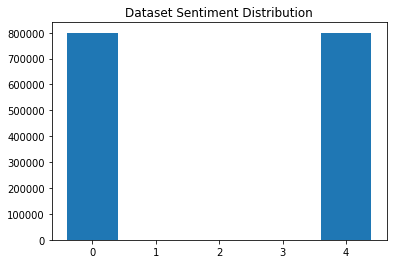

In [12]:
# no tweets were labeled as neutral in our training set, analyzing distribution of pos/neg
print(df_training.target.value_counts())

target_count = Counter(df_training['target'])

plt.bar(target_count.keys(), target_count.values())
plt.title("Dataset Sentiment Distribution")

'''

Distribution of positive and negative sentiments 

0 - negative sentiment
4 - positive sentiment

'''

In [13]:
'''
Notes:

- tweet date slightly negatively correlated with target sentiment, not useful enough for training 
- drop id and user for now, not strong enough correlation 

'''

df_training.corr()

,target,id,Year,month,day
target,1.000000,-0.261601,NaN,-0.163692,-0.086910
id,-0.261601,1.000000,NaN,0.846066,0.110995
Year,NaN,NaN,NaN,NaN,NaN
month,-0.163692,0.846066,NaN,1.000000,-0.425614
day,-0.086910,0.110995,NaN,-0.425614,1.000000


# Text Cleaning

In [14]:
# train only on the text information

df1 = df_training[['target', 'text']]
df1.rename(columns={'target':'label', 'text':'feature'}, inplace=True) # rename

C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [15]:
df1

,label,feature
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [16]:
'''

Using regex to parse and clean text features

HASH:
- extract all hashtags as a column: df1[hash]
- individual hashtags sometimes used to express overall emotion of message:
    - ex. #wow, #amazing, #fail

CLEAN1:
- dropping all retweets -> @****
- dropping all links -> http:\\****
- hashtag words are kept, but hashtag symbols are removed by CLEAN2
    - hashtag words sometimes used as part of sentence
        - ex. 

CLEAN2:
- keep all letters 

'''

HASH = '#(\w+)' # hashtags
CLEAN1 = '@(\w+)' # retweets
CLEAN2 = 'https?:\S+|http?:\S|www\.\S+' # links
CLEAN3 = '[^A-Za-z0-9\']+' # symbols

# create separate feature for hashtags only

df1['hash'] = df1['feature'].apply(lambda text: re.findall(r"#(\w+)", text)) # extract hashtags first

# function that replaces hashtag words with split words, in the feature column 

def replacehash(text):
    hash_words = re.findall(r"#(\w+)", text)
    for word in hash_words:
        text = text.replace(word, ' '.join(wordninja.split(word)))
    
    return text

df1['feature'] = df1['feature'].apply(lambda text: replacehash(text))

# applying CLEAN1 and CLEAN2 to remove all hashtags, retweets, links and symbols

df1['feature'] = df1['feature'].apply(lambda text: re.sub(CLEAN1, ' ', text.lower()).strip())
df1['feature'] = df1['feature'].apply(lambda text: re.sub(CLEAN2, ' ', text.lower()).strip())
df1['feature'] = df1['feature'].apply(lambda text: re.sub(CLEAN3, ' ', text.lower()).strip())

C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [17]:
df1

,label,feature,hash
0,0,awww that's a bummer you shoulda got david car...,[]
1,0,is upset that he can't update his facebook by ...,[]
2,0,i dived many times for the ball managed to sav...,[]
3,0,my whole body feels itchy and like its on fire,[]
4,0,no it's not behaving at all i'm mad why am i h...,[]
...,...,...,...
1599995,4,just woke up having no school is the best feel...,[]
1599996,4,thewdb com very cool to hear old walt interviews,[]
1599997,4,are you ready for your mojo makeover ask me fo...,[]
1599998,4,happy 38th birthday to my boo of alll time tup...,[]


In [18]:
'''
Using wordninja to split hashtag joined words
ex. '#charitytuesday' -> ['charity', 'tuesday']

- next steps, implementing wordninja in-house

'''

# splitwords takes a list of hashtag texts, uses wordninja to split each text into words, and joins all into a list

def splitwords(row):
    _list = []
    if len(row) == 0:
        pass
    else:
        for i in row:
            _list.append(wordninja.split(i))
    return [item for sublist in _list for item in sublist] 

# applying splitwords onto our hash column

df1['hash'] = df1['hash'].apply(lambda row: splitwords(row))

C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df1.iloc[15818]['hash']

['here', 'before', 'oprah']

# Feature Engineering

In [2]:
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet, reader
from nltk.stem import WordNetLemmatizer

In [21]:
# find features and create a featureset

#top_words = list(all_words.keys())[:5000]
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# mapper from nltk.pos_tag tags to wordnet tags

def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Find features takes a tweet and finds if each word in tweet can be found in top_words (top 5000 words from our training set)
# returns both the token list of words and the frequency of each token as dict

def preprocess(tweet):
    
    ''' for hash tweets (input is a list) '''
    if type(tweet) == list:
        tweet = ' '.join(tweet)
        
    ''' text lemmatization '''    
    words = word_tokenize(tweet)
    words = [word for word in words if word not in stop_words]
    words = pos_tag(words)
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in words]
    
#     freq = {}
#     for w in words:
#         freq[w] = (w in top_words)
    
    return words#, freq

In [22]:
# featuresets = [(find_features(rev), category) for (rev, category) in documents] # creating featuresets for aggregated all reviews

df1['tokens'] = df1['feature'].apply(lambda row: preprocess(row)) 
#df1['hash_tokens'] = df1['hash'].apply(lambda row: preprocess(row))

# df1['tokens'], df1['freq'] = features.apply(lambda row: row[0]), features.apply(lambda row: row[1])
# df1['hash_tokens'], df1['hash_freq'] = hash_features.apply(lambda row: row[0]), hash_features.apply(lambda row: row[1])

C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# pickling our training set to save

import pickle

save_set = open('df1.pickle', 'wb') # wb - write as bytes
pickle.dump(df1, save_set)

In [3]:
# loading a pickled training set for use

import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

load_set = open('df1.pickle', 'rb')
df1 = pickle.load(load_set)
load_set.close()

# create training and testing sets

train_size = 0.8 # 80% allocated to training

df_train, df_test = train_test_split(df1, test_size = 1-train_size, random_state=42)
print(len(df_train))
print(len(df_test))

# turn df_train['tokens'] into a list of list format

train_set = [row for row in df_train['tokens']]

1280000
320000


In [5]:
train_set

[['ya',
  'quot',
  "'d",
  'like',
  'palm',
  'pre',
  'touchstone',
  'charger',
  'readynow',
  'yes',
  'sound',
  'good',
  'beer',
  'ready',
  "'",
  'pre',
  'launch'],
 ['felt', 'earthquake', 'afternoon', 'seem', 'epicenter'],
 ['ruffle', 'shirt', 'like', 'likey'],
 ['pretty',
  'bad',
  'night',
  'crappy',
  'morning',
  'fml',
  'buttface',
  'didnt',
  'say',
  'could',
  'go',
  'work',
  'today'],
 ['yeah', 'clear', 'view'],
 ['one', 'time', 'follow', 'fam', 'ff', 'welcome', 'friday', 'follow', '2'],
 ['u', 'rock', 'thanks', 'add', 'next', 'robcrotch', 'tm', 'video'],
 ['yes',
  'please',
  'meet',
  'fiancee',
  'ian',
  "'s",
  'party',
  'day',
  'btw',
  "'s",
  'sweet',
  'congrats',
  'guy'],
 ['gawd',
  "'ve",
  'finish',
  'whole',
  'bowl',
  'even',
  'post',
  'previous',
  'tweet',
  'make',
  '2nd',
  'bowl'],
 ['awesome',
  'game',
  'short',
  "'ll",
  'finish',
  'crave',
  'god',
  'war',
  'action'],
 ['happy',
  'mother',
  'day',
  'grow',
  'n',
  '

In [5]:
''' Analysis of our set ''' 

# avg length of each tweet

avg = 0
for i in train_set:
    avg += len(i)
    
avg = avg/len(train_set)
print('Avg length of tweet: ', avg)

# freq of words

all_words = []

for i in train_set: # all words through all rows
    for word in i:
        all_words.append(word)

#all_words = nltk.FreqDist(all_words)

Avg length of tweet:  7.62029453125


In [6]:
df_train['tokens']

1374558    [ya, quot, 'd, like, palm, pre, touchstone, ch...
1389115       [felt, earthquake, afternoon, seem, epicenter]
1137831                         [ruffle, shirt, like, likey]
790714     [pretty, bad, night, crappy, morning, fml, but...
1117911                                  [yeah, clear, view]
                                 ...                        
259178     [song, 's, middle, change, n't, want, born, ar...
1414414                                         [good, luck]
131932                              [rather, average, 32370]
671155     [pickin, waitin, 2, hurry, odeeee, miss, dem, ...
121958        [home, study, math, wooot, im, go, fail, shit]
Name: tokens, Length: 1280000, dtype: object

In [7]:
all_words

['ya',
 'quot',
 "'d",
 'like',
 'palm',
 'pre',
 'touchstone',
 'charger',
 'readynow',
 'yes',
 'sound',
 'good',
 'beer',
 'ready',
 "'",
 'pre',
 'launch',
 'felt',
 'earthquake',
 'afternoon',
 'seem',
 'epicenter',
 'ruffle',
 'shirt',
 'like',
 'likey',
 'pretty',
 'bad',
 'night',
 'crappy',
 'morning',
 'fml',
 'buttface',
 'didnt',
 'say',
 'could',
 'go',
 'work',
 'today',
 'yeah',
 'clear',
 'view',
 'one',
 'time',
 'follow',
 'fam',
 'ff',
 'welcome',
 'friday',
 'follow',
 '2',
 'u',
 'rock',
 'thanks',
 'add',
 'next',
 'robcrotch',
 'tm',
 'video',
 'yes',
 'please',
 'meet',
 'fiancee',
 'ian',
 "'s",
 'party',
 'day',
 'btw',
 "'s",
 'sweet',
 'congrats',
 'guy',
 'gawd',
 "'ve",
 'finish',
 'whole',
 'bowl',
 'even',
 'post',
 'previous',
 'tweet',
 'make',
 '2nd',
 'bowl',
 'awesome',
 'game',
 'short',
 "'ll",
 'finish',
 'crave',
 'god',
 'war',
 'action',
 'happy',
 'mother',
 'day',
 'grow',
 'n',
 'happy',
 'amp',
 'lil',
 'prego',
 'smut',
 'lol',
 'play',
 

# Word Embedding with Gensim Model

In [20]:
import gensim
from gensim.models import Word2Vec

In [7]:
'''
Create Word2Vec model on our data

- in order to create word embeddings for our training words
- embed words by context neighbors

'''

# setting vocabulary parameters

model_size = 256 # dimensionality of dense vector to represent word - # of context neighboring words we want
model_window = 8 # max distance between target word and neighboring words in sentence, outliers are not considered similar
model_min_count = 10 # ignore infrequent words
model_workers = 4 # distibution of threads to use
model_epochs = 32 # number of epochs over corpus

# building word2vec model on train_set

cbow_model = gensim.models.word2vec.Word2Vec(min_count=model_min_count, 
                                            size=model_size, 
                                            window=model_window, 
                                            workers=model_workers)

In [8]:
cbow_model.build_vocab(train_set)
print('Vocab size: ', len(cbow_model.wv.vocab.keys()))

2020-09-22 21:51:18,413 : INFO : collecting all words and their counts
2020-09-22 21:51:18,414 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-22 21:51:18,438 : INFO : PROGRESS: at sentence #10000, processed 76693 words, keeping 11785 word types
2020-09-22 21:51:18,465 : INFO : PROGRESS: at sentence #20000, processed 152763 words, keeping 18074 word types
2020-09-22 21:51:18,493 : INFO : PROGRESS: at sentence #30000, processed 228267 words, keeping 23014 word types
2020-09-22 21:51:18,526 : INFO : PROGRESS: at sentence #40000, processed 304919 words, keeping 27350 word types
2020-09-22 21:51:18,561 : INFO : PROGRESS: at sentence #50000, processed 380604 words, keeping 31367 word types
2020-09-22 21:51:18,592 : INFO : PROGRESS: at sentence #60000, processed 456306 words, keeping 35121 word types
2020-09-22 21:51:18,619 : INFO : PROGRESS: at sentence #70000, processed 532012 words, keeping 38611 word types
2020-09-22 21:51:18,649 : INFO : PROGRESS: at s

2020-09-22 21:51:20,682 : INFO : PROGRESS: at sentence #720000, processed 5491863 words, keeping 162195 word types
2020-09-22 21:51:20,716 : INFO : PROGRESS: at sentence #730000, processed 5567462 words, keeping 163597 word types
2020-09-22 21:51:20,748 : INFO : PROGRESS: at sentence #740000, processed 5643612 words, keeping 164952 word types
2020-09-22 21:51:20,779 : INFO : PROGRESS: at sentence #750000, processed 5719459 words, keeping 166281 word types
2020-09-22 21:51:20,811 : INFO : PROGRESS: at sentence #760000, processed 5795667 words, keeping 167631 word types
2020-09-22 21:51:20,842 : INFO : PROGRESS: at sentence #770000, processed 5872341 words, keeping 169033 word types
2020-09-22 21:51:20,872 : INFO : PROGRESS: at sentence #780000, processed 5947706 words, keeping 170365 word types
2020-09-22 21:51:20,898 : INFO : PROGRESS: at sentence #790000, processed 6024561 words, keeping 171842 word types
2020-09-22 21:51:20,924 : INFO : PROGRESS: at sentence #800000, processed 610150

Vocab size:  25762


In [9]:
%%time

cbow_model.train(train_set, total_examples=len(train_set),epochs=model_epochs)

2020-09-22 21:51:34,196 : INFO : training model with 4 workers on 25762 vocabulary and 256 features, using sg=0 hs=0 sample=0.001 negative=5 window=8
2020-09-22 21:51:35,238 : INFO : EPOCH 1 - PROGRESS: at 9.45% examples, 784475 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:51:36,245 : INFO : EPOCH 1 - PROGRESS: at 20.20% examples, 838076 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:51:37,265 : INFO : EPOCH 1 - PROGRESS: at 31.16% examples, 858097 words/s, in_qsize 8, out_qsize 1
2020-09-22 21:51:38,268 : INFO : EPOCH 1 - PROGRESS: at 41.69% examples, 863400 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:51:39,274 : INFO : EPOCH 1 - PROGRESS: at 52.32% examples, 867459 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:51:40,278 : INFO : EPOCH 1 - PROGRESS: at 63.48% examples, 877554 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:51:41,289 : INFO : EPOCH 1 - PROGRESS: at 75.58% examples, 895042 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:51:42,295 : INFO : EPOCH 1 - PROGRESS: at 87.1

2020-09-22 21:52:26,030 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 21:52:26,040 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 21:52:26,049 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 21:52:26,051 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 21:52:26,052 : INFO : EPOCH - 6 : training on 9753977 raw words (8346132 effective words) took 8.5s, 978619 effective words/s
2020-09-22 21:52:27,073 : INFO : EPOCH 7 - PROGRESS: at 12.12% examples, 1005888 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:52:28,077 : INFO : EPOCH 7 - PROGRESS: at 24.09% examples, 1001281 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:52:29,083 : INFO : EPOCH 7 - PROGRESS: at 36.27% examples, 1004596 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:52:30,084 : INFO : EPOCH 7 - PROGRESS: at 47.43% examples, 986320 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:52:31,089 : INFO : EPOCH 7 - P

2020-09-22 21:53:16,134 : INFO : EPOCH 12 - PROGRESS: at 59.29% examples, 820848 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:53:17,142 : INFO : EPOCH 12 - PROGRESS: at 69.12% examples, 820120 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:53:18,154 : INFO : EPOCH 12 - PROGRESS: at 79.29% examples, 822203 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:53:19,155 : INFO : EPOCH 12 - PROGRESS: at 90.68% examples, 836086 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:53:19,932 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 21:53:19,939 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 21:53:19,945 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 21:53:19,952 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 21:53:19,953 : INFO : EPOCH - 12 : training on 9753977 raw words (8348569 effective words) took 9.9s, 847179 effective words/s
2020-09-22 21:53:20,968 : INFO : EPOCH 13 

2020-09-22 21:54:06,625 : INFO : EPOCH 18 - PROGRESS: at 35.05% examples, 971379 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:54:07,629 : INFO : EPOCH 18 - PROGRESS: at 46.09% examples, 958656 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:54:08,645 : INFO : EPOCH 18 - PROGRESS: at 57.24% examples, 950578 words/s, in_qsize 8, out_qsize 0
2020-09-22 21:54:09,644 : INFO : EPOCH 18 - PROGRESS: at 68.51% examples, 949038 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:54:10,650 : INFO : EPOCH 18 - PROGRESS: at 78.98% examples, 937358 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:54:11,654 : INFO : EPOCH 18 - PROGRESS: at 89.85% examples, 933165 words/s, in_qsize 8, out_qsize 0
2020-09-22 21:54:12,569 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 21:54:12,571 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 21:54:12,576 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 21:54:12,582 : INFO : worker thr

2020-09-22 21:54:57,404 : INFO : EPOCH - 23 : training on 9753977 raw words (8348793 effective words) took 8.9s, 937470 effective words/s
2020-09-22 21:54:58,423 : INFO : EPOCH 24 - PROGRESS: at 10.89% examples, 903107 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:54:59,425 : INFO : EPOCH 24 - PROGRESS: at 22.87% examples, 950674 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:00,426 : INFO : EPOCH 24 - PROGRESS: at 34.44% examples, 955479 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:01,436 : INFO : EPOCH 24 - PROGRESS: at 44.97% examples, 934671 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:02,437 : INFO : EPOCH 24 - PROGRESS: at 55.49% examples, 923897 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:03,444 : INFO : EPOCH 24 - PROGRESS: at 65.64% examples, 910035 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:04,445 : INFO : EPOCH 24 - PROGRESS: at 77.33% examples, 919300 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:05,454 : INFO : EPOCH 24 - PROGRESS: at 88.52% 

2020-09-22 21:55:50,408 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-22 21:55:50,415 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-22 21:55:50,420 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-22 21:55:50,422 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-22 21:55:50,424 : INFO : EPOCH - 29 : training on 9753977 raw words (8348049 effective words) took 9.0s, 932734 effective words/s
2020-09-22 21:55:51,448 : INFO : EPOCH 30 - PROGRESS: at 10.58% examples, 873667 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:52,463 : INFO : EPOCH 30 - PROGRESS: at 22.15% examples, 913016 words/s, in_qsize 8, out_qsize 0
2020-09-22 21:55:53,465 : INFO : EPOCH 30 - PROGRESS: at 33.62% examples, 927259 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:54,470 : INFO : EPOCH 30 - PROGRESS: at 45.69% examples, 946536 words/s, in_qsize 7, out_qsize 0
2020-09-22 21:55:55,476 : INFO : EPOCH 30 

Wall time: 4min 43s


(267124459, 312127264)

In [15]:
# most similar words

cbow_model.wv.most_similar('great')

[('fantastic', 0.7758585214614868),
 ('wonderful', 0.7226381301879883),
 ('good', 0.6906130313873291),
 ('awesome', 0.6826470494270325),
 ('amazing', 0.6501271724700928),
 ('fabulous', 0.6395999193191528),
 ('excellent', 0.6273428201675415),
 ('fab', 0.6175312995910645),
 ('nice', 0.5801827907562256),
 ('amaze', 0.5740725994110107)]

In [16]:
print('Length of array: ', len(cbow_model["love"]))
cbow_model["love"]

Length of array:  256


C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 0.44429505,  0.23518018,  0.06412721,  1.2245287 ,  1.0157188 ,
       -0.3377532 , -1.207964  , -0.25429347,  0.9659266 , -0.5499973 ,
       -1.0439688 ,  1.5073498 ,  0.9097087 ,  1.4931809 , -0.82146996,
       -0.30336332, -1.6721662 , -1.0133312 ,  0.95516783, -0.945025  ,
       -0.22023506,  1.2074769 ,  0.7996962 , -0.79653096,  0.6997143 ,
       -0.36372596, -0.08584122, -0.45974258,  0.34157288,  0.9178934 ,
        1.8157425 ,  0.54358864, -0.5472745 ,  0.6433603 ,  0.4254519 ,
        0.9968094 , -0.9540379 ,  1.2603736 ,  1.382922  , -0.75961983,
       -1.2407627 , -0.652299  , -0.90325624, -0.33656508, -0.13726255,
       -0.70761377, -1.4578966 ,  0.630882  , -2.774012  , -1.031076  ,
        0.69106287,  1.3046227 , -0.09744342, -0.13449739, -0.49499324,
       -0.19178785, -1.2465953 ,  0.44321957,  0.4177703 ,  2.0692544 ,
       -0.51653224,  0.11155434,  0.67808074,  1.2080457 ,  0.9004645 ,
        1.2117167 ,  0.8216612 ,  0.11337686,  1.2734159 ,  0.99

In [17]:
# saving our cbow model

cbow_model.save('cbow_model.bin')

2020-09-22 21:58:42,379 : INFO : saving Word2Vec object under cbow_model.bin, separately None
2020-09-22 21:58:42,380 : INFO : not storing attribute vectors_norm
2020-09-22 21:58:42,382 : INFO : not storing attribute cum_table
2020-09-22 21:58:43,354 : INFO : saved cbow_model.bin


In [21]:
# loading our cbow model

Model = Word2Vec.load('cbow_model.bin')

2020-09-22 21:59:42,248 : INFO : loading Word2Vec object from cbow_model.bin
2020-09-22 21:59:42,717 : INFO : loading wv recursively from cbow_model.bin.wv.* with mmap=None
2020-09-22 21:59:42,718 : INFO : setting ignored attribute vectors_norm to None
2020-09-22 21:59:42,719 : INFO : loading vocabulary recursively from cbow_model.bin.vocabulary.* with mmap=None
2020-09-22 21:59:42,720 : INFO : loading trainables recursively from cbow_model.bin.trainables.* with mmap=None
2020-09-22 21:59:42,721 : INFO : setting ignored attribute cum_table to None
2020-09-22 21:59:42,722 : INFO : loaded cbow_model.bin


In [23]:
Model.wv.most_similar('great')

[('fantastic', 0.7758585214614868),
 ('wonderful', 0.7226381301879883),
 ('good', 0.6906130313873291),
 ('awesome', 0.6826470494270325),
 ('amazing', 0.6501271724700928),
 ('fabulous', 0.6395999193191528),
 ('excellent', 0.6273428201675415),
 ('fab', 0.6175312995910645),
 ('nice', 0.5801827907562256),
 ('amaze', 0.5740725994110107)]

In [24]:
df_train

,label,feature,hash,tokens
1374558,4,with ya quot i'd like a palm pre touchstone ch...,"[pre, launch]","[ya, quot, 'd, like, palm, pre, touchstone, ch..."
1389115,4,felt the earthquake this afternoon it seems to...,[],"[felt, earthquake, afternoon, seem, epicenter]"
1137831,4,ruffles on shirts are like so in me likey,[],"[ruffle, shirt, like, likey]"
790714,0,pretty bad night into a crappy morning fml if ...,[],"[pretty, bad, night, crappy, morning, fml, but..."
1117911,4,yeah what a clear view,[],"[yeah, clear, view]"
...,...,...,...,...
259178,0,this song's middle change just doesn't want to...,[],"[song, 's, middle, change, n't, want, born, ar..."
1414414,4,good luck with that,[],"[good, luck]"
131932,0,i rather average 32370,[],"[rather, average, 32370]"
671155,0,pickin up waitin on 2 hurry up i odeeee missed...,[],"[pickin, waitin, 2, hurry, odeeee, miss, dem, ..."


### Preprocess Features

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [27]:
%%time
'''
Use tokenizer to vectorize our tweets - map each tweet as sequence of integers of where text occurs
    EX. tokenizer.fit_on_texts("The earth is an awesome place live")
        ->     [[1,2,3,4,5,6,7]] where 3:"is" , 6:"place", etc.
'''

# create vocabulary index dictionary - on word freq

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['feature'])
vocab_size = len(tokenizer.word_index) + 1

print("Total words", vocab_size)

Total words 258269
Wall time: 35 s


In [28]:
df_train['feature']

1374558    with ya quot i'd like a palm pre touchstone ch...
1389115    felt the earthquake this afternoon it seems to...
1137831            ruffles on shirts are like so in me likey
790714     pretty bad night into a crappy morning fml if ...
1117911                               yeah what a clear view
                                 ...                        
259178     this song's middle change just doesn't want to...
1414414                                  good luck with that
131932                                i rather average 32370
671155     pickin up waitin on 2 hurry up i odeeee missed...
121958     home studying for maths wooot im so going to f...
Name: feature, Length: 1280000, dtype: object

In [29]:
%%time

# transform tweets from training data to a sequence of integers based on our created dictionary

encoded_train = tokenizer.texts_to_sequences(df_train['feature'])
encoded_test = tokenizer.texts_to_sequences(df_test['feature'])

# pad documents to a consistent array length of 300

max_length = 300 # pad all x vectors to be uniform 300 length

x_training = pad_sequences(encoded_train, maxlen=max_length, padding='pre') # prepadding adds 0s before sequence up to length 300
x_testing = pad_sequences(encoded_test, maxlen=max_length, padding='pre')

# x_training is 1280000 x 300 matrix, with 1280000 rows (training samples), each sample padded to a length 300 tokenized vector

print(x_training) 
print('Shape: ', x_training.shape)

[[     0      0      0 ...    701   1269   2375]
 [     0      0      0 ...     23      3  32888]
 [     0      0      0 ...     10     14   5671]
 ...
 [     0      0      0 ...    792   4423 258268]
 [     0      0      0 ...      2     22   1104]
 [     0      0      0 ...    602     26    383]]
Shape:  (1280000, 300)
Wall time: 41.8 s


### Create Embedded Matrix

In [30]:
%%time

'''
For each word in our features, we first encode it to vector by position through encoding tokenizer,
then map it to the word vector we have trained using Model (W2V)

Model (W2V cbow):
- has 25762 unique words
    - from training set (tweet lists that are tokenized, lemmatized, remove stop words)
- each word as 256 length array of floats
- training words with 'distance' to 256 neighbor words


Encoding Tokenizer:
- has 258269 words
    - from training set (raw string of tweet)
- each word as 300 length array of ints  
- our training features that are processed for learning

Created an embedding matrix that we will use as matrix of weights for our embedding layer, initialized by our W2V model
'''

# now apply the trained w2v model onto our training set

embedding_matrix = np.zeros((vocab_size, model_size)) # shape: 258269 x 256  

for word, i in tokenizer.word_index.items():
    if word in Model.wv.vocab:
        embedding_vector = Model.wv[word] # 256 length vector for each word in Model
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        
'''
embedding matrix:shape:

shape: 258269 x 256  

array(
        [

            [Model[1]],
            [Model[2]],
            ...

        ]
    )

where
Model[2]:

array([len(256)]) that represent 256 'distances' to neighbors of 'to' (tokenizer.word_index['to'] = 2)

'''

print(embedding_matrix)
print('Shape: ', embedding_matrix.shape)
print('Parameters: ', embedding_matrix.shape[0] * embedding_matrix.shape[1])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0113766  -0.01582396  0.08579604 ...  0.48666427  0.15633571
   0.31762081]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Shape:  (258269, 256)
Parameters:  66116864
Wall time: 225 ms


### Encoding Labels

In [31]:
%%time

# mapper for sentiment labels

sent_map = {0:'Negative', 2: 'Neutral', 4:'Positive'}

train_labels = df_train['label'].tolist()
test_labels = df_test['label'].tolist()

# relabelling our labels using sklearn.preprocessing's labelencoder

label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

'''
Labels will be from 0-1
    - {0:'Negative', 1:'Positive'}
    - neutral not present in dataset when we trained LabelEncoder()
    
Labels will be transformed from column of df_train
    => np.array where (1280000, 1) for y_training
    => basically to retain original shape of 1280000 rows, 1 column in numpy.array form

''' 

y_training = label_encoder.transform(train_labels)
y_test = label_encoder.transform(test_labels)

y_training = y_training.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# reshape to training to be (1280000, 1), where we have one column and 1280000 rows to match our 1280000 training sample

print(y_training)
print('Shape: ', y_training.shape)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
Shape:  (1280000, 1)
Wall time: 598 ms


# RNN LSTM Model

In [32]:
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

from datetime import datetime

In [33]:
# Instantiate Keras Model

model = Sequential()

# embedding layer
emb_layer = Embedding(vocab_size, model_size, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(emb_layer)
model.add(Dropout(0.3))
# LSTM cell
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 256)          66116864  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,314,113
Trainable params: 197,249
Non-trainable params: 66,116,864
_________________________________________________________________


### Compile Model 

In [34]:
# configure model for training

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

2020-09-22 22:12:13,524 : WARNING : From C:\Users\jymas\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
# setting parameters

N_EPOCHS = 8 # iterations to train
BATCHES = 1024 # samples/gradient update
VAL_SPLIT = 0.1 # set aside 10% for validation before testing

LOG_DIR = 'logs/{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))

# callback monitoring
# possibly include remotemonitor for eventual streaming, modelcheckpoint for saving

CALLBACKS = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), # reduce learning rate once val_loss stops improving
            EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5), # stopping training when val_accuracy stops improving
           TensorBoard(log_dir=LOG_DIR, histogram_freq=1)]
print(LOG_DIR)

logs/20200922-224048


In [38]:
trained_model = model.fit(x_training,
                          y_training,
                          epochs=N_EPOCHS,
                          batch_size=BATCHES,
                          validation_split=VAL_SPLIT,
                          verbose=1,
                         callbacks=CALLBACKS)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 1385s 1ms/step - loss: 0.4679 - accuracy: 0.7754 - val_loss: 0.4457 - val_accuracy: 0.7914


KeyboardInterrupt: 

In [ ]:
n_epochs = 10
n_classes = 2
batch_size = 128

chunk_size = 256 # should be length of the tweet
n_chunks = None

rnn_size = 128

def recurrent_neural_network(x):
    
    # creating embedding layer
    emb_layer = tf.convert_to_tensor(embedding_matrix, np.float32)
    
    layer = {'weights':tf.Variable(emb_layer, tf.random_normal([n_classes]))
            'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(0, n_chunks, x)
    
    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size)
    
    outputs, states = rnn.rnn(lstm_cell, x, dtype=tf.float32)
    
    # (matmul of final output with weights) + biases
    output = tf.matmul(outputs[-1], layer['weights']) + layer['biases']
    
    return output

#def train_neural_network(x):
    